In [56]:
#----------------------------------------
#
#    💥💻LOF
#  
#----------------------------------------

from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# --- 1. Vectorizar de nuevo los datos filtrados ---
X_full = tfidf_vectorizer.transform(data_filtrado['Nombre_Limpio']).toarray()
y_full = data_filtrado['SubRubro_encoded_relabel']

# Usaremos el set vectorizado (sin SMOTE)
X_for_lof = X_full  # TF-IDF

# Crear el modelo LOF
lof = LocalOutlierFactor(
    n_neighbors=20,    # Número de vecinos a considerar (puede probarse 10, 20, 30)
    contamination=0.05 # Estimación inicial: se espera que el 5% sean outliers
)

# Ajustar el modelo y predecir
y_lof_pred = lof.fit_predict(X_for_lof)

# Interpretación:
# -1 = outlier (anómalo)
#  1 = inlier (normal)

# Agregar la predicción al dataset
data_filtrado['LOF_Prediccion'] = y_lof_pred

# Mostrar conteo
print(data_filtrado['LOF_Prediccion'].value_counts())

# Opcional: ver algunos ejemplos de outliers detectados
outliers_detectados = data_filtrado[data_filtrado['LOF_Prediccion'] == -1]
print("\nAlgunos productos detectados como atípicos por LOF:")
print(outliers_detectados[['Nombre', 'Descripcion']].head(10))


LOF_Prediccion
 1    3887
-1      10
Name: count, dtype: int64

Algunos productos detectados como atípicos por LOF:
                                                 Nombre  \
1046                        PIGTAILS RF SMA TO SMA 5G30   
1329  F.O DROP CABLE FLAT FIG8 DIELEC CORE ARAMID LS...   
1517  SILLA ESCRITORIO ERGONOMICA MODELO NEW(NEGRO) ...   
1804                     PIGTAIL RPSMA-RPSMA 50CM RG402   
2213                  DISTRIBUIDOR BORNERA BIPOLAR 125A   
2595  SWITCH ARUBA 1420 24G GIGABIT LAYER2 2SFP- NO ...   
3016                      CAJA PC 8 SALIDAS-48 FUSIONES   
3042  KIT OLT MA5800-X2 Incluye: Chasis, 1 Controlad...   
3296                                 ALAMBRE NEGRO X KG   
3836                                    RAEES ALUMINIO    

                                            Descripcion  
1046                                                NaN  
1329       AR-2PEUFS-1FA2-1HC-SC/APC-80M (PROYECTO ANR)  
1517                                                NaN  
18

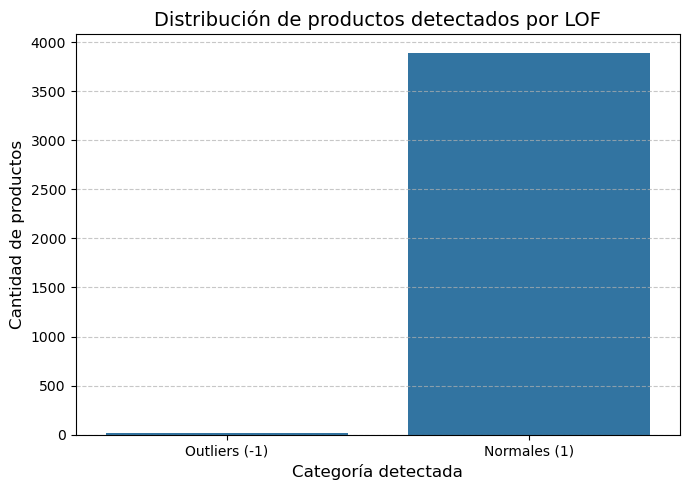

In [33]:
#----------------------------------------
#
#    💥💻LOF
#  
#----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Suponemos que ya ejecutaste esto antes:
# data_filtrado['LOF_Prediccion']  # -1 = outlier, 1 = normal

# Contar la cantidad de normales y outliers
conteo_lof = data_filtrado['LOF_Prediccion'].value_counts().sort_index()
conteo_lof.index = ['Outliers (-1)', 'Normales (1)']  # Etiquetas más claras

# Crear gráfico de barras
plt.figure(figsize=(7, 5))
sns.barplot(x=conteo_lof.index, y=conteo_lof.values)

# Títulos y etiquetas
#plt.title("Distribución de productos detectados por LOF", fontsize=14 ,palette='Set2', legend=False)
plt.title("Distribución de productos detectados por LOF", fontsize=14)
plt.ylabel("Cantidad de productos", fontsize=12)
plt.xlabel("Categoría detectada", fontsize=12)

# Mejoras visuales
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar gráfico
plt.show()

    

In [29]:
#----------------------------------------
#
#    💥💻DBSCAN
#  
#----------------------------------------
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

# Usamos el mismo conjunto que para LOF
X_for_dbscan = X_full  # TF-IDF

# Crear modelo DBSCAN
dbscan = DBSCAN(
    eps=1.5,          # Distancia máxima entre dos puntos para ser vecinos (ajustable)
    min_samples=5,    # Mínimo número de puntos en un vecindario para formar un cluster
    metric='cosine'   # Métrica para TF-IDF (coseno funciona mejor que euclidiana)
)

# Ajustar y predecir
dbscan_labels = dbscan.fit_predict(X_for_dbscan)

# Interpretación:
# -1 = ruido (outlier)
# 0, 1, 2, ... = clusters encontrados

# Agregar la predicción al DataFrame
data_filtrado['DBSCAN_Cluster'] = dbscan_labels

# Mostrar conteo de outliers y clusters
print(data_filtrado['DBSCAN_Cluster'].value_counts().sort_index())

# Opcional: ver algunos ejemplos detectados como ruido
outliers_dbscan = data_filtrado[data_filtrado['DBSCAN_Cluster'] == -1]
print("\nAlgunos productos detectados como ruido por DBSCAN:")
print(outliers_dbscan[['Nombre', 'Descripcion']].head(10))


DBSCAN_Cluster
0    3803
Name: count, dtype: int64

Algunos productos detectados como ruido por DBSCAN:
Empty DataFrame
Columns: [Nombre, Descripcion]
Index: []


Cantidad de clusters encontrados: 1
Cantidad de productos detectados como ruido (outliers): 0


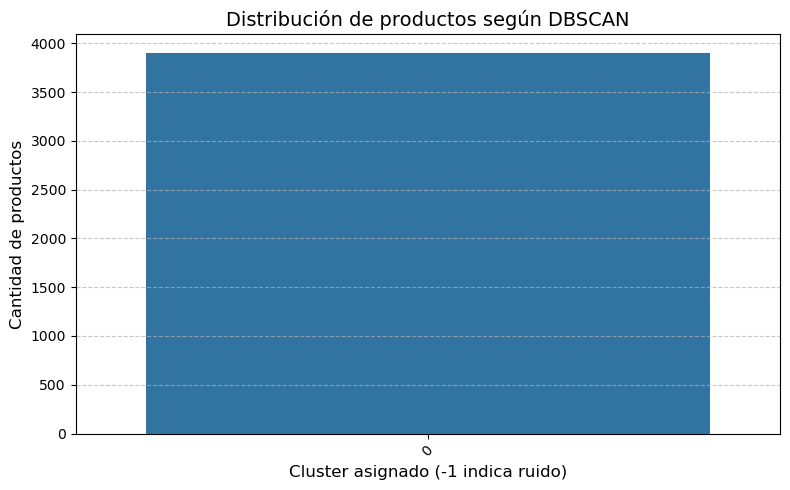


Algunos productos detectados como ruido por DBSCAN:
Empty DataFrame
Columns: [Nombre, Descripcion]
Index: []


In [34]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicar DBSCAN
X_for_dbscan = X_full  # TF-IDF sin PCA

dbscan = DBSCAN(
    eps=1.5,           # Distancia máxima entre vecinos
    min_samples=5,     # Mínimo número de vecinos
    metric='cosine'    # Métrica adecuada para vectores TF-IDF
)

dbscan_labels = dbscan.fit_predict(X_for_dbscan)

# Agregar los resultados al dataset
data_filtrado['DBSCAN_Cluster'] = dbscan_labels

# 2. Conteo de resultados
conteo_dbscan = data_filtrado['DBSCAN_Cluster'].value_counts().sort_index()

# Separar cantidad de ruido y clusters
n_ruido = (conteo_dbscan.index == -1).sum()
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"Cantidad de clusters encontrados: {n_clusters}")
print(f"Cantidad de productos detectados como ruido (outliers): {(dbscan_labels == -1).sum()}")

# 3. Gráfico de barras de Clusters y Ruido
plt.figure(figsize=(8, 5))
sns.countplot(x='DBSCAN_Cluster', data=data_filtrado)
plt.title('Distribución de productos según DBSCAN', fontsize=14)
plt.xlabel('Cluster asignado (-1 indica ruido)', fontsize=12)
plt.ylabel('Cantidad de productos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Opcional: ver ejemplos de productos detectados como ruido
outliers_dbscan = data_filtrado[data_filtrado['DBSCAN_Cluster'] == -1]
print("\nAlgunos productos detectados como ruido por DBSCAN:")
print(outliers_dbscan[['Nombre', 'Descripcion']].head(10))


Cantidad de clusters encontrados: 89
Cantidad de productos detectados como ruido (outliers): 1136


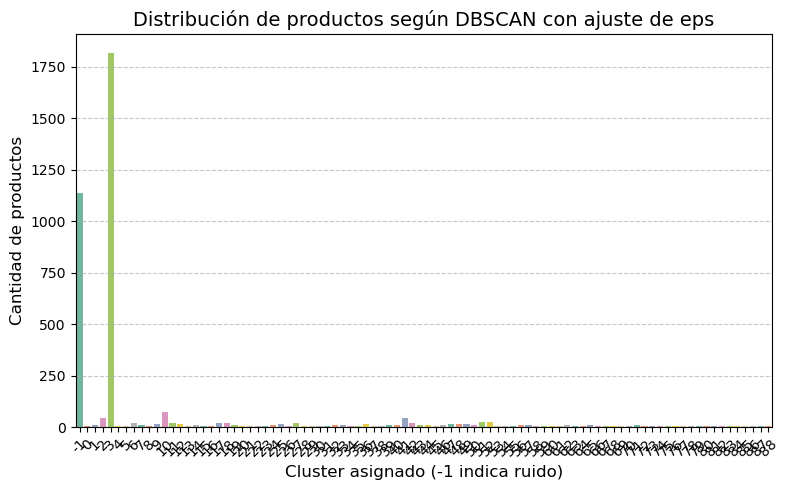


Algunos productos detectados como ruido por DBSCAN:
                            Nombre                             Descripcion
2                  ROPA DE TRABAJO                                     NaN
3       COMBUSTIBLES Y LUBRICANTES            COMBUSTIBLES Y LUBRINCANTES.
7                           RESMAS                            RESMAS AUTOR
8                        PAPELERÍA                         PAPELES- HOJAS.
13        TORRES MET. MANO DE OBRA         TORRES METALICAS - MANO DE OBRA
18                           TOKEN                          TOKEN E CRYPTO
24           ANTENA PANEL MIKROTIK              ANTENA TIPO PANEL MIKROTIK
26  ELECTRODOMÉSTICOS P/LA EMPRESA  ELECTRODOMÉSTICOS P/ USO DE LA EMPRESA
28                       CAFETERAS          CAFETERAS P/ USO DE LA EMPRESA
32                          CÁMARA                                 CÁMARA 


In [35]:
#Debemos bajar el valor de eps para que DBSCAN sea más estricto.
# eps=0.3,       # Mucho más estricto
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicar DBSCAN
X_for_dbscan = X_full  # TF-IDF sin PCA

dbscan = DBSCAN(
    eps=0.6,       # Mucho más estricto
    min_samples=5,     # Mínimo número de vecinos
    metric='cosine'    # Métrica adecuada para vectores TF-IDF
)

dbscan_labels = dbscan.fit_predict(X_for_dbscan)

# Agregar los resultados al dataset
data_filtrado['DBSCAN_Cluster'] = dbscan_labels

# 2. Conteo de resultados
conteo_dbscan = data_filtrado['DBSCAN_Cluster'].value_counts().sort_index()

# Separar cantidad de ruido y clusters
n_ruido = (conteo_dbscan.index == -1).sum()
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"Cantidad de clusters encontrados: {n_clusters}")
print(f"Cantidad de productos detectados como ruido (outliers): {(dbscan_labels == -1).sum()}")

# 3. Gráfico de barras de Clusters y Ruido
plt.figure(figsize=(8, 5))
sns.countplot(x='DBSCAN_Cluster', data=data_filtrado, palette='Set2')
plt.title('Distribución de productos según DBSCAN con ajuste de eps', fontsize=14)
plt.xlabel('Cluster asignado (-1 indica ruido)', fontsize=12)
plt.ylabel('Cantidad de productos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Opcional: ver ejemplos de productos detectados como ruido
outliers_dbscan = data_filtrado[data_filtrado['DBSCAN_Cluster'] == -1]
print("\nAlgunos productos detectados como ruido por DBSCAN:")
print(outliers_dbscan[['Nombre', 'Descripcion']].head(10))


In [35]:
# Filtrar productos detectados como outliers en LOF y DBSCAN
outliers_ambos = data_filtrado[
    (data_filtrado['LOF_Prediccion'] == -1) & (data_filtrado['DBSCAN_Cluster'] == -1)
]

# Mostrar algunos ejemplos
print("Productos detectados como atípicos por ambos algoritmos:")
print(outliers_ambos[['Nombre', 'Descripcion']].head(10))

# Mostrar cantidad
print(f"\nCantidad de productos detectados como outliers por LOF y DBSCAN simultáneamente: {outliers_ambos.shape[0]}")


Productos detectados como atípicos por ambos algoritmos:
                                                 Nombre Descripcion
71    PELA CABLE PROSKIT 8PK-CT001                  ...         NaN
331   BOBINA UTP CAT 6 (EN MT SUELTO)               ...   CABLE UTP
676                        PELA CABLE PROSKIT 8PK-CT001  PELA CABLE
731   TENAZA CARPINTERO CARPINTERO N8               ...      TENAZA
770   JABALINA AC-COBR 1.5MTS- 3/8" C-TOMAC C-SELLO-...    JABALINA
970   EXTENSION M22 320 MM                          ...         NaN
1109  CART. HP CO. N°93                             ...    C9361TRI
1110  CART. HP NE. N°92                             ...     C9362WL
1139  CARTUCHO HP 662 XL NEGRO                      ...         NaN
1140  CARTUCHO HP 662 XL COLOR                      ...         NaN

Cantidad de productos detectados como outliers por LOF y DBSCAN simultáneamente: 71
